# Analyze Representations in Path-Integrating RNN

Model from "Conformal Isometry of Lie Group Representation in Recurrent Network of Grid Cells" Xu, et al. 2022. (https://arxiv.org/abs/2210.02684)

### Set Up + Imports

In [67]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import torch

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


### Load trained model config, activations, loss

In [68]:
from neurometry.datasets.load_rnn_grid_cells import load_rate_maps, load_config

# run_id = "20240418-180712"
run_id = "20240504-020404"
step_before = 25000
step_after = 30000

activations_before = load_rate_maps(run_id, step_before)
activations_after = load_rate_maps(run_id, step_after)

config = load_config(run_id)

Visualize rate maps

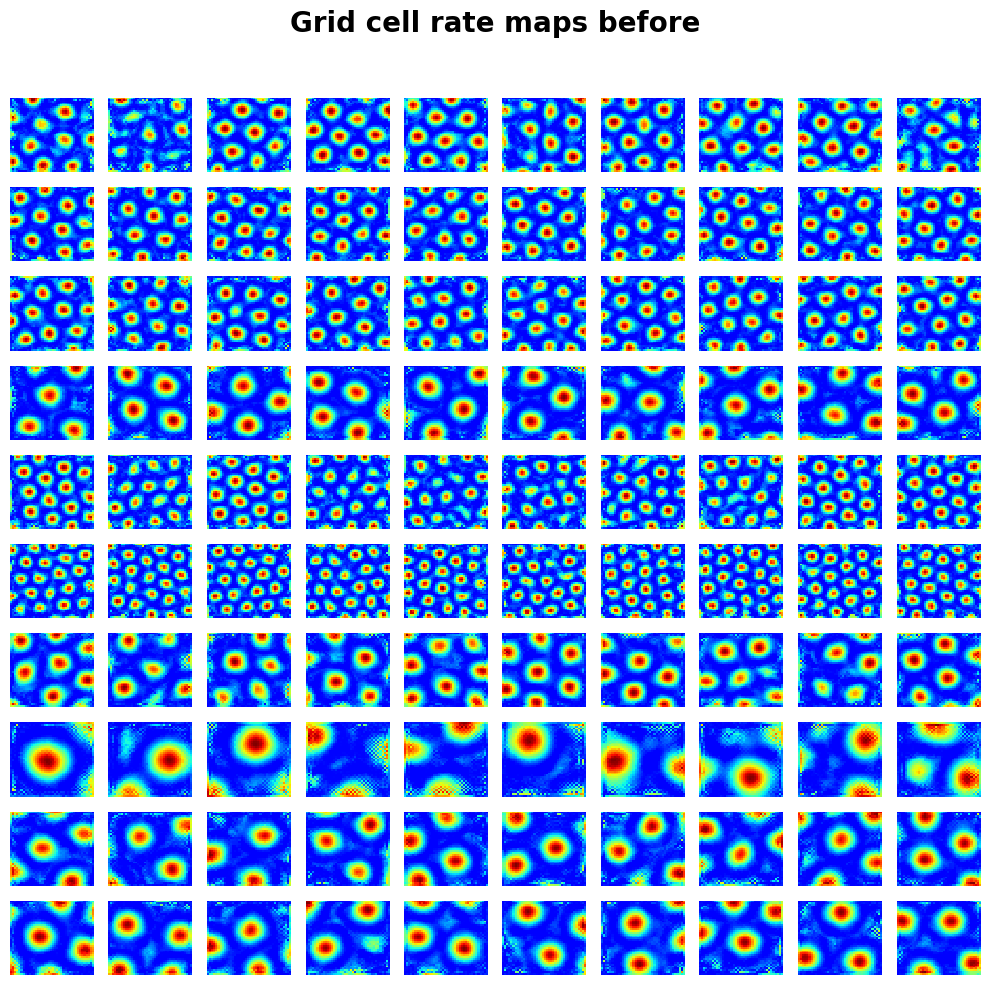

In [69]:
from neurometry.datasets.load_rnn_grid_cells import draw_heatmap

block_size = config["model"]["block_size"]
num_grid = config["model"]["num_grid"]

draw_heatmap(
    activations_before["v"].reshape(-1, block_size, num_grid, num_grid)[:10, :10],
    title="Grid cell rate maps before",
);

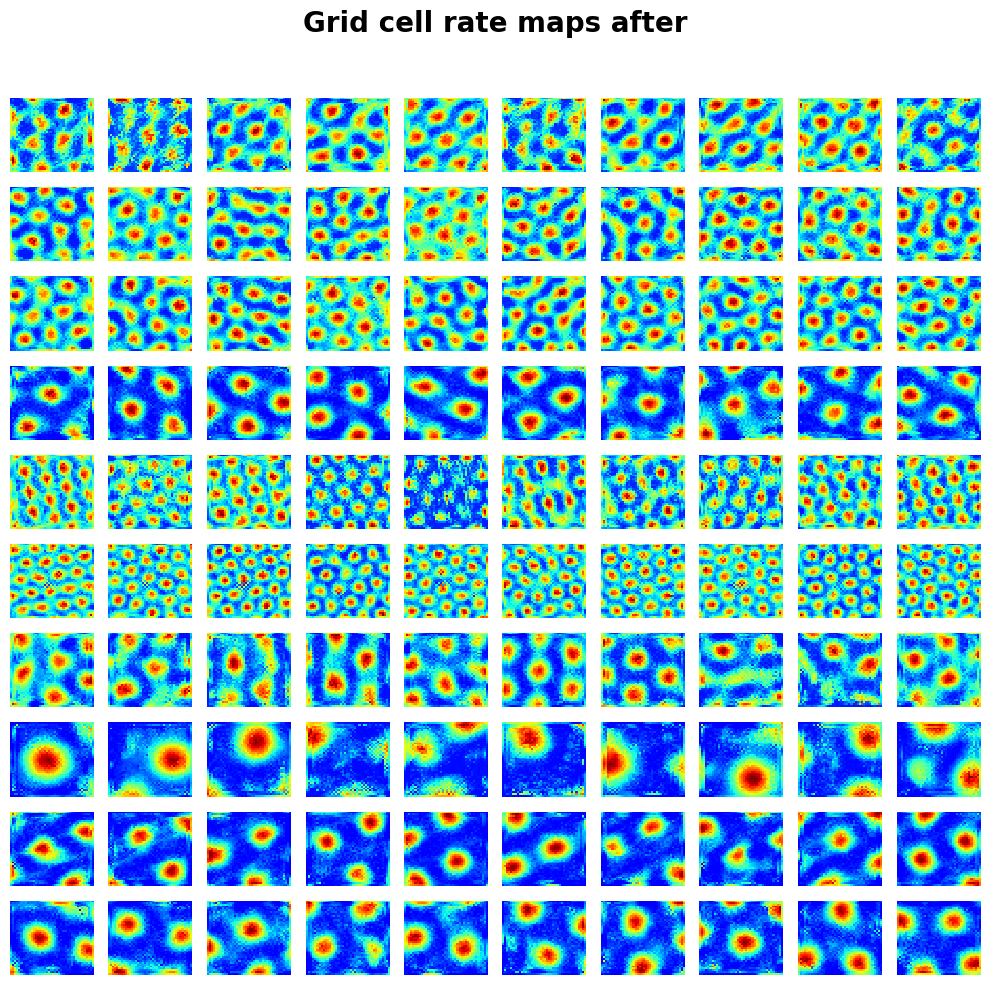

In [70]:
draw_heatmap(
    activations_after["v"].reshape(-1, block_size, num_grid, num_grid)[:10, :10],
    title="Grid cell rate maps after",
);

Visualize total loss through training

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


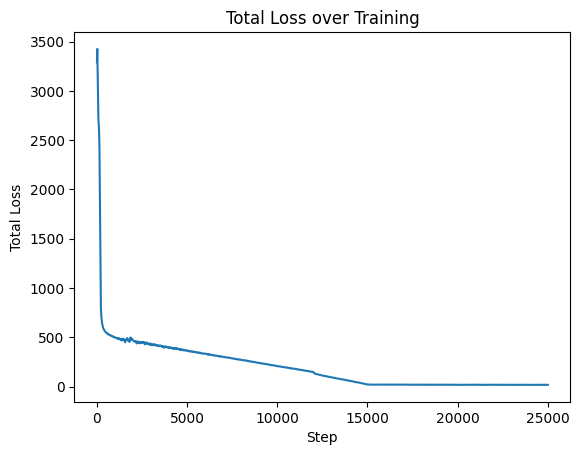

In [66]:
from neurometry.datasets.load_rnn_grid_cells import extract_tensor_events

run_dir = os.path.join(
    os.getcwd(),
    "curvature/grid-cells-curvature/models/xu_rnn/logs/rnn_isometry/20240418-180712",
)

event_file = os.path.join(run_dir, "events.out.tfevents.1713488846.hall.2392205.0.v2")
all_tensor_data, losses = extract_tensor_events(event_file, verbose=False)

loss_vals = [l["loss"] for l in losses]
loss_steps = [l["step"] for l in losses]

plt.plot(loss_steps, loss_vals)
plt.xlabel("Step")
plt.ylabel("Total Loss")
plt.title("Total Loss over Training");

### Compute grid scores, spatial autocorrelations (SACs)

In [75]:
from neurometry.datasets.load_rnn_grid_cells import get_scores

scores = get_scores(run_dir, activations_before, config)

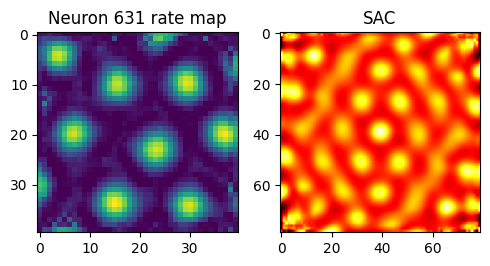

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

cell_id = 631

axes[0].imshow(activations_before["v"][cell_id])
axes[0].set_title(f"Neuron {cell_id} rate map")
axes[1].imshow(scores["sac"][cell_id], cmap="hot")
axes[1].set_title("SAC")
plt.tight_layout()

### Compute 2D fourier transform of the rate maps

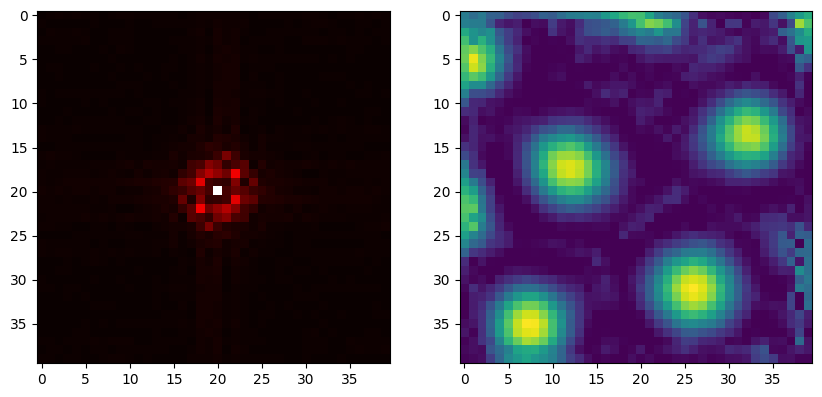

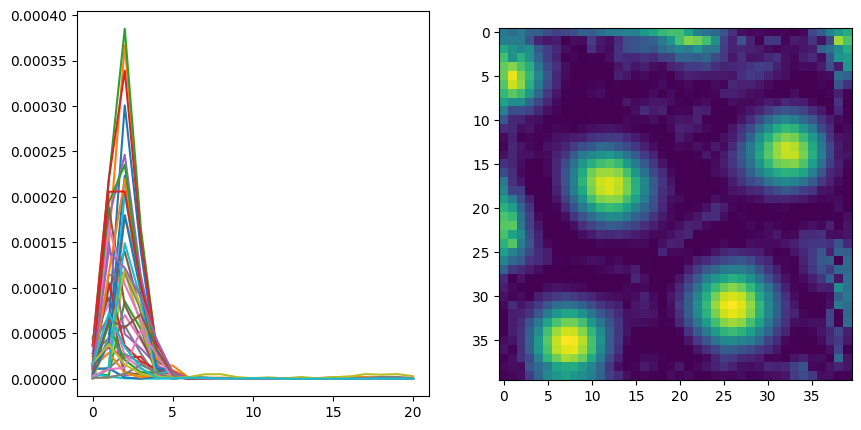

In [8]:
from scipy.fftpack import fft2, fftshift

fft_rate_maps = np.array([fftshift(fft2(rate_map)) for rate_map in activations['v']])

# visualize the 2D fourier transform of the rate map for a single cell

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cell_id = 201

axes[0].imshow(np.abs(fft_rate_maps[cell_id]), cmap="hot");
axes[1].imshow(activations['v'][cell_id]);

# estimate the spectral density of the rate maps

from scipy.signal import welch

frequencies, psd = welch(activations['v'], fs=40, nperseg=40, axis=1)

# visualize the spectral density of the rate maps for a single cell

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

cell_id = 201 

axes[0].plot(frequencies, psd[cell_id]);

axes[1].imshow(activations['v'][cell_id]);

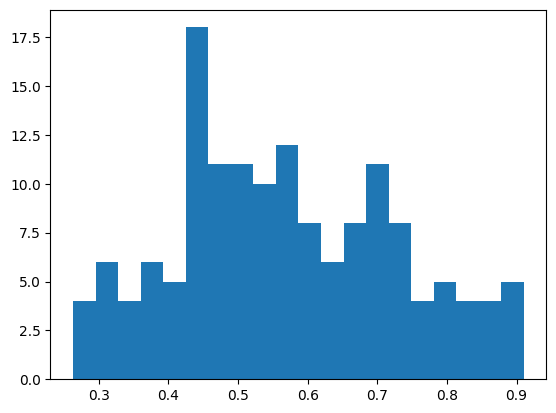

In [9]:
plt.hist(scale_tensor, bins=20);

### Define subpolations based on UMAP on spatial autocorrelation scores

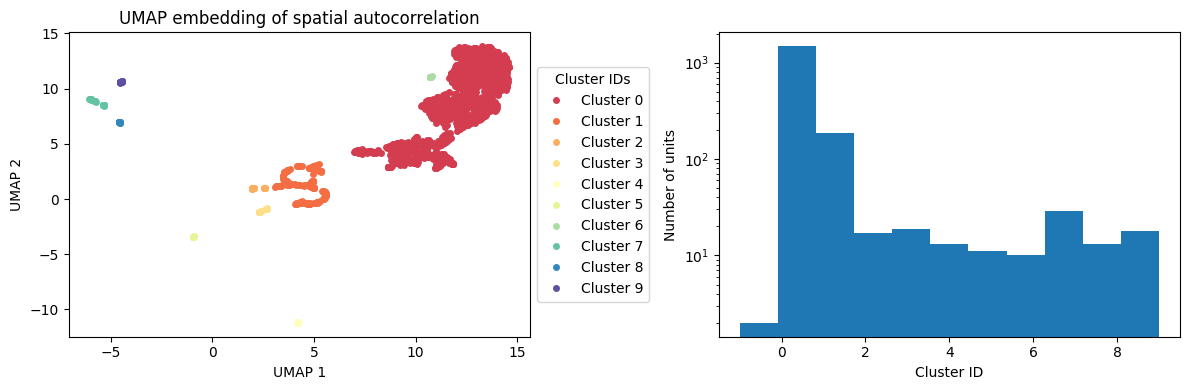

In [82]:
from neurometry.datasets.load_rnn_grid_cells import umap_dbscan

clusters_before, umap_cluster_labels = umap_dbscan(
    activations_before["v"], run_dir, config, sac_array=None, plot=True
)

There are 29 units in cluster 7


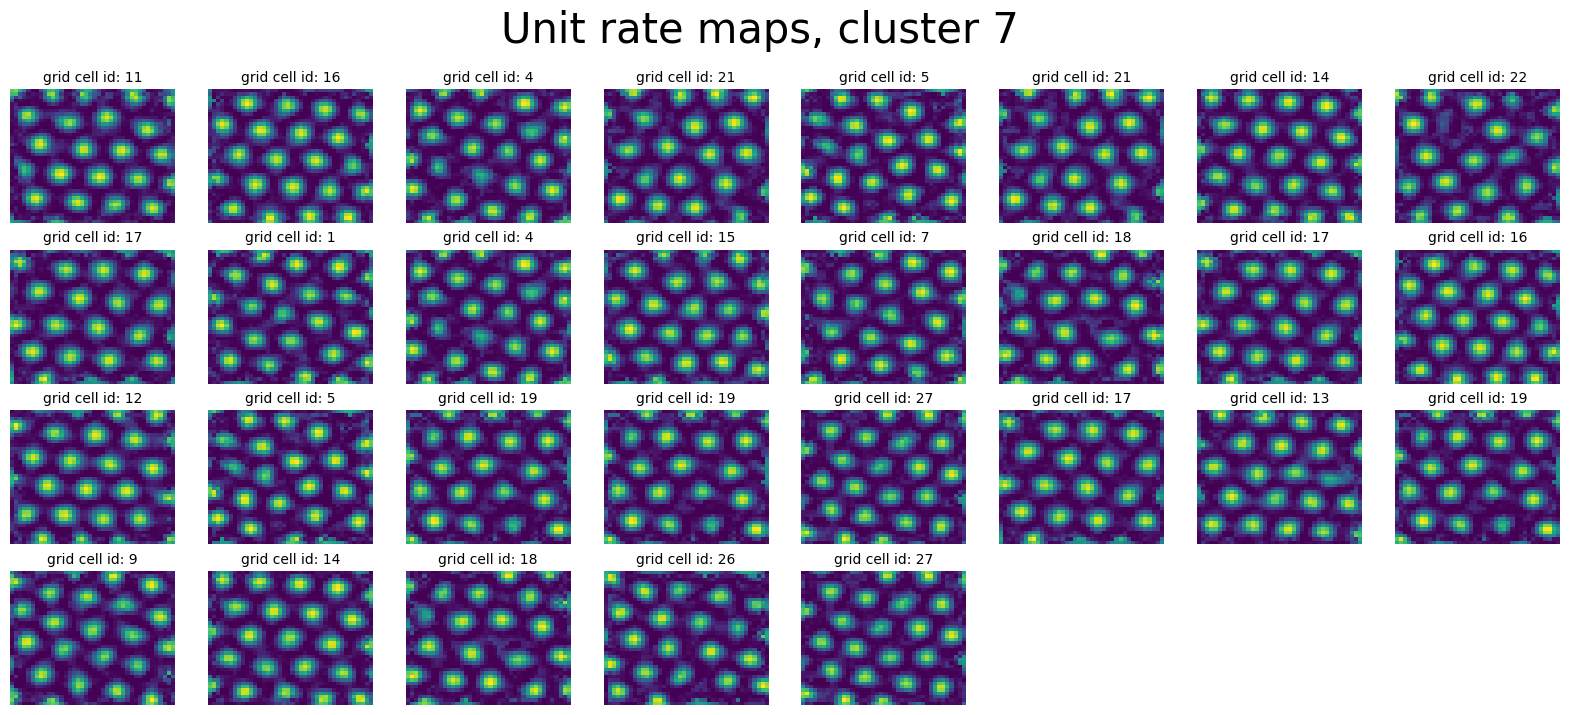

In [83]:
from neurometry.datasets.load_rnn_grid_cells import plot_rate_map

cluster_id = 7

num_cells_in_cluster = clusters_before[cluster_id].shape[0]
print(f"There are {num_cells_in_cluster} units in cluster {cluster_id}")

plot_rate_map(
    None,
    min(40, num_cells_in_cluster),
    clusters_before[cluster_id],
    f"Unit rate maps, cluster {cluster_id}",
)

neural_points_before = (
    clusters_before[cluster_id].reshape(len(clusters_before[cluster_id]), -1).T
)

(1600, 29)


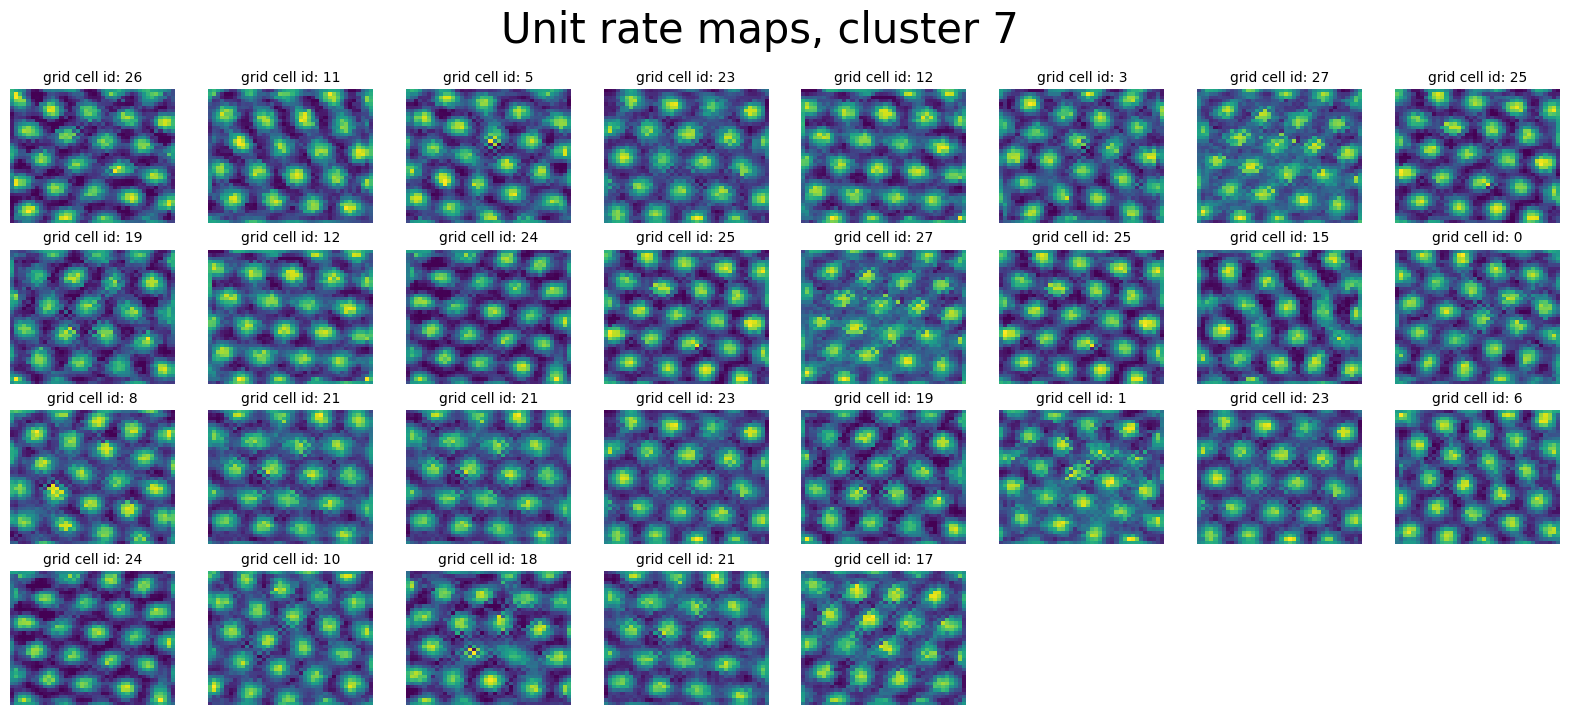

In [84]:
clusters_after = {}
for i in np.unique(umap_cluster_labels):
    cluster = activations_after["v"][umap_cluster_labels == i]
    clusters_after[i] = cluster

neural_points_after = (
    clusters_after[cluster_id].reshape(len(clusters_after[cluster_id]), -1).T
)
print(neural_points_after.shape)

plot_rate_map(
    None,
    min(40, num_cells_in_cluster),
    clusters_after[cluster_id],
    f"Unit rate maps, cluster {cluster_id}",
)

### Or: define subpopulation using predefined "blocks"

(1600, 150)


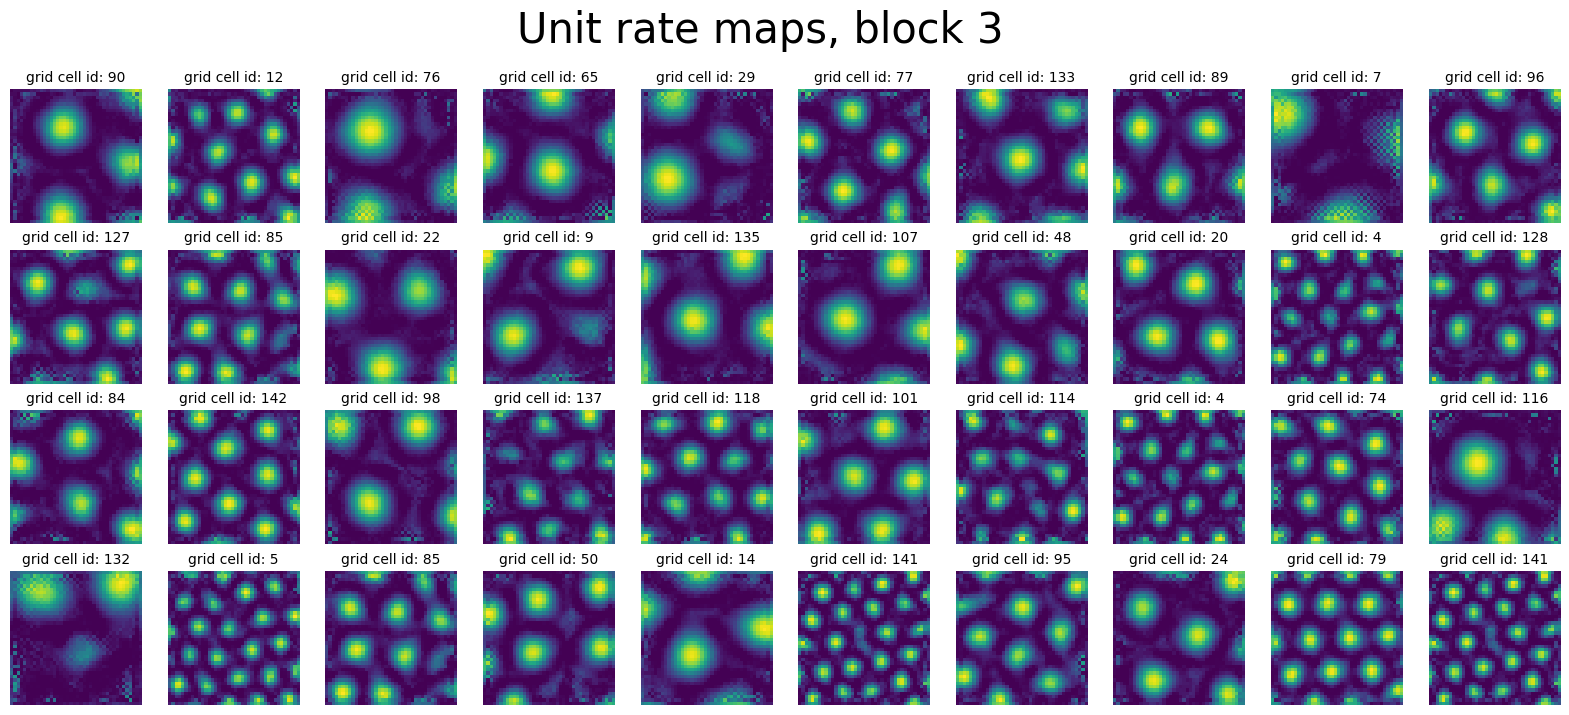

In [143]:
block_id = 3


activations_block = activations_before["v"].reshape(-1, block_size, num_grid, num_grid)[
    :, block_id, :, :
]

block_neural_points = activations_block.reshape(-1, num_grid * num_grid).T

print(block_neural_points.shape)

plot_rate_map(
    None,
    min(40, 150),
    activations_block,
    f"Unit rate maps, block {block_id}",
)

### Cohomological Coordinates on Grid Cell Module Torus

In [94]:
from neurometry.topology.persistent_homology import compute_persistence_diagrams
from sklearn.decomposition import PCA

pca_before = PCA(n_components=6)

neural_points_pca_before = pca_before.fit_transform(neural_points_before)
diagrams_before = compute_persistence_diagrams(
    [neural_points_pca_before], homology_dimensions=(0, 1)
)

# pca_after = PCA(n_components=6)

# neural_points_pca_after = pca_after.fit_transform(neural_points_after)
# diagrams_after = compute_persistence_diagrams([neural_points_pca_after])

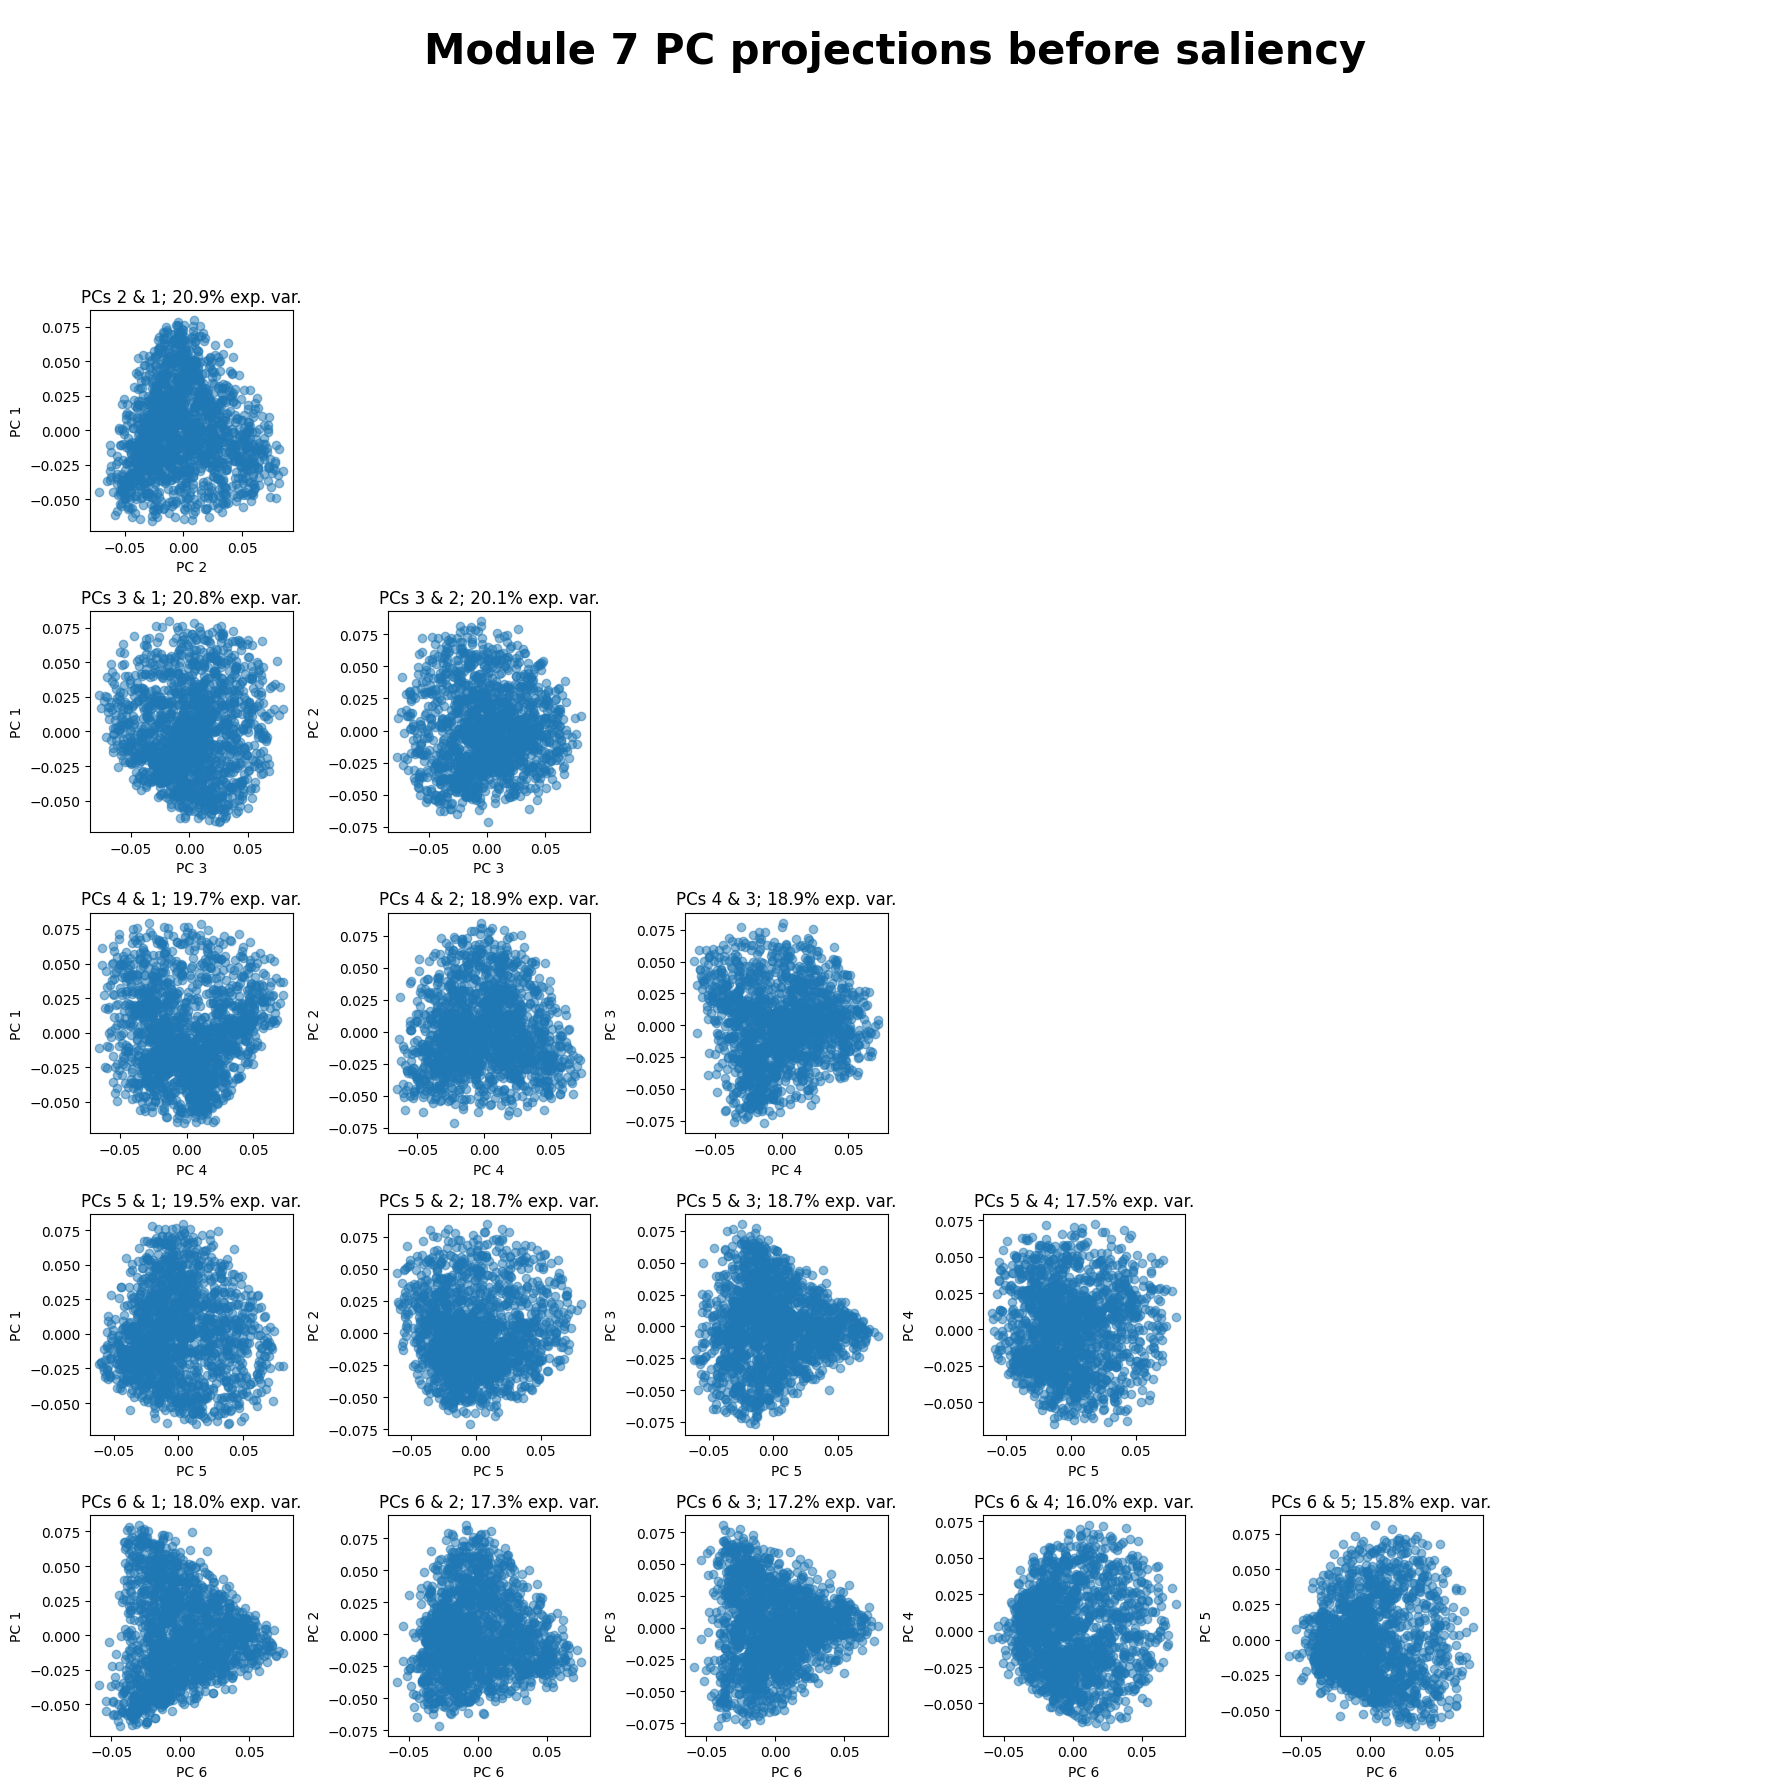

The 6 top PCs explain 55.59% of the variance


In [90]:
from neurometry.dimension.dim_reduction import plot_pca_projections

plot_pca_projections(
    neural_points_before,
    K=6,
    title=f"Module {cluster_id} PC projections before saliency",
);

noise level: 2.24%


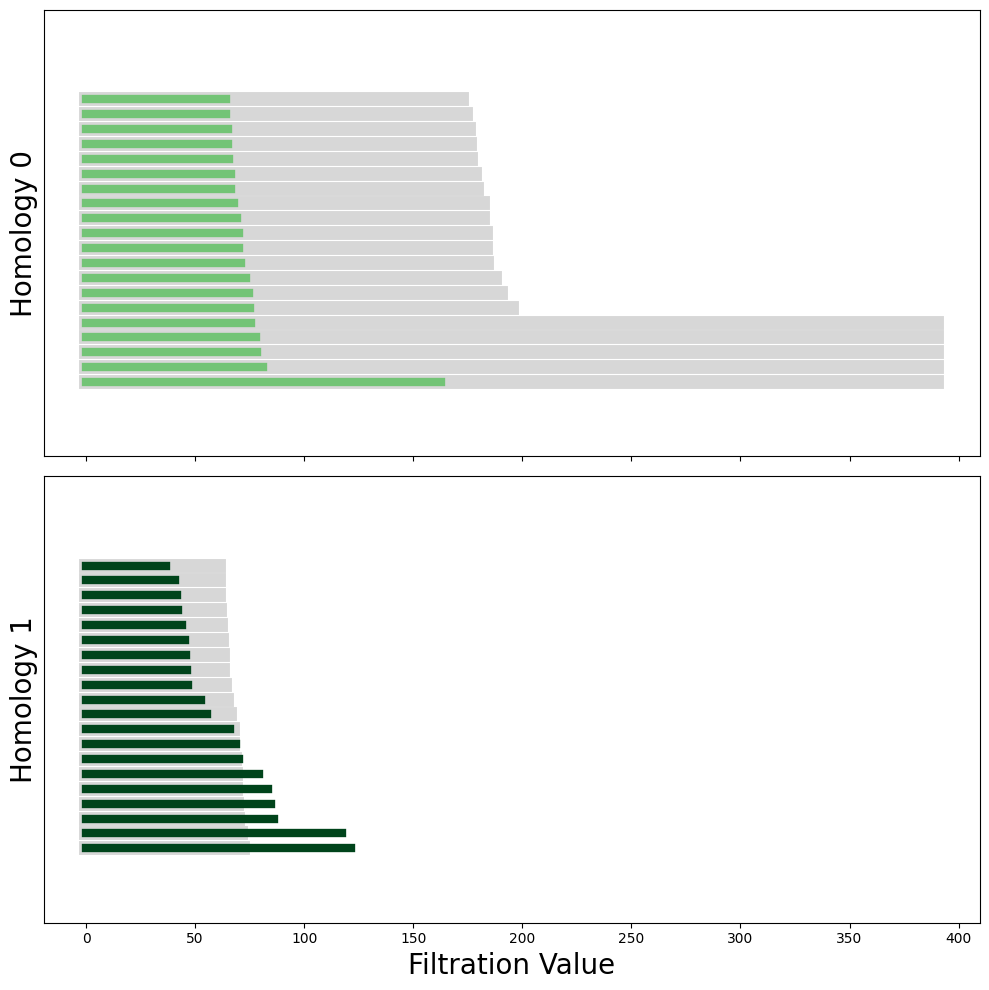

In [323]:
from neurometry.datasets.synthetic import hypertorus

torus = hypertorus(2, 500)

X, _ = synthetic_neural_manifold(
    torus, 6, "tanh", scales=gs.ones(6), poisson_multiplier=10
)

from neurometry.topology.persistent_homology import compute_diagrams_shuffle

diagrams = compute_diagrams_shuffle(X, 5)

from neurometry.topology.plotting import plot_all_barcodes_with_null

plot_all_barcodes_with_null(diagrams)

In [326]:
from neurometry.topology.persistent_homology import cohomological_toroidal_coordinates

from neurometry.topology.plotting import plot_activity_on_torus

toroidal_coords = cohomological_toroidal_coordinates(neural_points_pca_before)
fig = plot_activity_on_torus(neural_points_before, toroidal_coords, neuron_id=13)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False);

In [127]:
neuron_id1 = 13
neuron_id2 = 27

fig = plot_activity_on_torus(
    neural_points_before, toroidal_coords, neuron_id=neuron_id1, neuron_id2=neuron_id2
)

# save to html file
# fig.write_html(f"torus_neuron_neurons_{neuron_id1}_{neuron_id2}_.html")

### PCA / UMAP / Isomap

In [150]:
# visualize 3d projection of the neural points using pca and plotly

from sklearn.decomposition import PCA
from plotly import express as px

pca = PCA(n_components=3)
pca.fit(neural_points_before)
neural_points_pca = pca.transform(neural_points_before)

fig = px.scatter_3d(
    x=neural_points_pca[:, 0],
    y=neural_points_pca[:, 1],
    z=neural_points_pca[:, 2],
    opacity=1,
    title="3D PCA projection of neural points",
)

#change point size 
fig.update_traces(marker=dict(size=2))

fig.update_traces(marker=dict(color=Y[:,0]))

fig.show()

In [1]:
# visualize 3d projection of the neural points using umap and plotly

umap_reducer_3d = umap.UMAP(n_components=3, random_state=10)
umap_embedding_3d = umap_reducer_3d.fit_transform(neural_points)

fig = px.scatter_3d(
    x=umap_embedding_3d[:, 0],
    y=umap_embedding_3d[:, 1],
    z=umap_embedding_3d[:, 2],
    opacity=0.9,
    title="3D UMAP projection of neural points",
)

fig.update_traces(marker=dict(size=4))


fig.update_traces(marker=dict(color=neural_points[:,0]))

fig.show()

import plotly.io as pio

# Save the figure to an HTML file
#pio.write_html(fig, file='umap_3d_projection.html')

NameError: name 'umap' is not defined

### Dimensionality Estimation

(1600, 2)


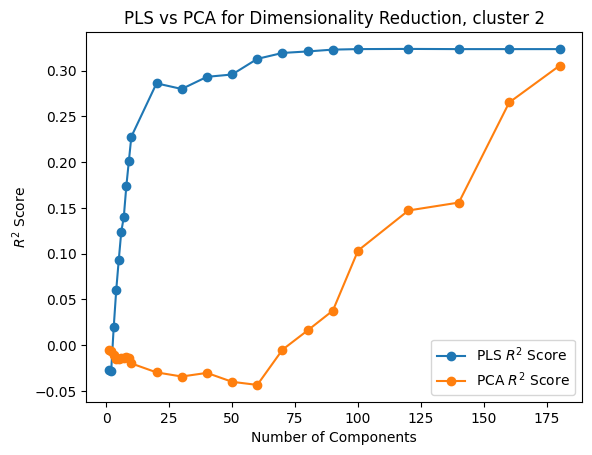

In [139]:
box_width = 1
res = 40

bin_edges = np.linspace(0, box_width, res + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

x_centers, y_centers = np.meshgrid(bin_centers, bin_centers[::-1])

positions_array = np.stack([x_centers, y_centers], axis=-1)

# Flatten the coordinate array to shape (400, 2)
positions = positions_array.reshape(-1, 2)


print(positions.shape)


X = neural_points
Y = positions

from neurometry.dimension.dimension import (
    evaluate_PCA_with_different_K,
    evaluate_pls_with_different_K,
)

K_values = [*range(1,10),*range(10,100,10),*range(100,200,20)]
# K_values = [*range(1,10),*range(10,30,5)]

pca_r2_scores, pca_transformed_X = evaluate_PCA_with_different_K(X, Y, K_values)

pls_r2_scores, pls_transformed_X = evaluate_pls_with_different_K(X, Y, K_values)

plt.plot(K_values, pls_r2_scores, marker="o", label="PLS $R^2$ Score")

plt.plot(K_values, pca_r2_scores, marker="o", label="PCA $R^2$ Score")

plt.xlabel("Number of Components")

plt.ylabel("$R^2$ Score")

plt.title(f"PLS vs PCA for Dimensionality Reduction, cluster {cluster_id}")

plt.legend();

In [143]:
# visualize 3d projection of the neural points using pca and plotly

from sklearn.decomposition import PCA
from plotly import express as px

pca = PCA(n_components=3)
pca.fit(pls_transformed_X[20])
neural_points_pls_pca = pca.transform(pls_transformed_X[20])

fig = px.scatter_3d(
    x=neural_points_pca[:, 0],
    y=neural_points_pca[:, 1],
    z=neural_points_pca[:, 2],
    opacity=1,
    title="3D PCA projection of neural points",
)

#change point size 
fig.update_traces(marker=dict(size=2))

fig.update_traces(marker=dict(color=Y[:,0]))

fig.show()

In [144]:
# visualize 3d projection of the neural points using umap and plotly

umap_reducer_3d = umap.UMAP(n_components=3, random_state=10)
umap_embedding_3d = umap_reducer_3d.fit_transform(pls_transformed_X[20])

fig = px.scatter_3d(
    x=umap_embedding_3d[:, 0],
    y=umap_embedding_3d[:, 1],
    z=umap_embedding_3d[:, 2],
    opacity=0.7,
    title="3D UMAP projection of neural points",
)

fig.update_traces(marker=dict(size=4))


fig.update_traces(marker=dict(color=Y[:,1]))

fig.show()

In [145]:
# visualize 3d projection of the neural points using isomap and plotly

from sklearn.manifold import Isomap

isomap = Isomap(n_components=3)
isomap_embedding = isomap.fit_transform(pls_transformed_X[20])

fig = px.scatter_3d(
    x=isomap_embedding[:, 0],
    y=isomap_embedding[:, 1],
    z=isomap_embedding[:, 2],
    opacity=0.7,
    title="3D Isomap projection of neural points",
)

fig.update_traces(marker=dict(size=4))

fig.update_traces(marker=dict(color=Y[:,1]))

fig.show()

### Persistent Homology

In [146]:
from neurometry.topology.persistent_homology import compute_persistence_diagrams
from gtda.plotting import plot_diagram

In [57]:
diagrams = compute_persistence_diagrams([neural_points])

fig = plot_diagram(diagrams[0])

fig.update_layout(title=f"Persistence Diagram, Cluster {cluster_id}; Full state space")

In [147]:
diagrams_pls = compute_persistence_diagrams([pls_transformed_X[20]])

In [69]:
fig_pls = plot_diagram(diagrams_pls[0])

fig_pls.update_layout(title=f"Persistence Diagram, Cluster {cluster_id}; PLS 40 components")

In [71]:
diagrams_pca = compute_persistence_diagrams([pca_transformed_X[5]])

plot_diagram(diagrams_pca[0])

fig_pls.update_layout(title=f"Persistence Diagram, Cluster {cluster_id}; PCA 6 components")

In [19]:
weighted_diagrams = compute_persistence_diagrams([neural_points], weighted=True)
plot_diagram(weighted_diagrams[0])

In [33]:
import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs  # noqa: E402
from geomstats.geometry.base import ImmersedSet  # noqa: E402
from geomstats.geometry.pullback_metric import PullbackMetric  # noqa: E402
from geomstats.geometry.euclidean import Euclidean # noqa: E402


class NeuralManifoldIntrinsic(ImmersedSet):
    def __init__(self, dim, neural_embedding_dim, neural_immersion, equip=True):
        self.neural_embedding_dim = neural_embedding_dim
        super().__init__(dim=dim, equip=equip)
        self.neural_immersion = neural_immersion
        #self.neural_embedding_dim = neural_embedding_dim

    def immersion(self, point):
        return self.neural_immersion(point)
    
    def _define_embedding_space(self):
        return Euclidean(dim=self.neural_embedding_dim)

In [34]:
major_radius = 2
minor_radius = 1
def neural_immersion(point):
    theta = point[..., 0]
    phi = point[..., 1]
    x = (major_radius - minor_radius * gs.cos(theta)) * gs.cos(phi)
    y = (major_radius - minor_radius * gs.cos(theta)) * gs.sin(phi)
    z = minor_radius * gs.sin(theta)
    return gs.stack([x,y,z],axis=-1)

dim = 2
neural_embedding_dim = 3

neural_manifold = NeuralManifoldIntrinsic(dim, neural_embedding_dim, neural_immersion, equip=False)
neural_manifold.equip_with_metric(PullbackMetric)

In [37]:
z = gs.array([0.5, 0.5])

neural_manifold.metric.mean_curvature_vector(z)

tensor([ 0.1680,  0.0918, -0.1046])

In [38]:
neural_manifold.metric.mean_curvature_vector(z)

tensor([ 0.1680,  0.0918, -0.1046])

In [40]:
neural_manifold.metric.metric_matrix(z)

tensor([[1.0000e+00, 2.7756e-17],
        [2.7756e-17, 1.2598e+00]])

In [41]:
gs.linalg.inv(neural_manifold.metric.metric_matrix(z))

tensor([[ 1.0000e+00, -2.2031e-17],
        [-2.2031e-17,  7.9376e-01]])